In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import RobustScaler

In [13]:
df = pd.read_csv('./data/strokes.csv')
df.sample(10)

id  gender   age  hypertension  heart_disease ever_married  \
3914  15098  Female  65.0             0              0          Yes   
1657  48210    Male  59.0             0              0          Yes   
919    3606    Male   8.0             0              0           No   
780   42441    Male   7.0             0              0           No   
641   23650    Male  15.0             0              0           No   
4631  10445    Male  54.0             0              0          Yes   
4314  21067  Female  45.0             0              0          Yes   
4204   7047  Female  31.0             0              0          Yes   
756   49785  Female  18.0             0              0           No   
3489  57539  Female  68.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi smoking_status  \
3914        Private          Rural              95.87  29.8   never smoked   
1657        Private          Rural              64.51  31.5   never smoked   
919        children          Urban             111.02  22.4        Unknown   
780        children          Urban             152.81  17.7        Unknown   
641        children          Rural              85.06  21.6   never smoked   
4631       Govt_job          Rural              81.78  27.3        Unknown   
4314  Self-employed          Urban             110.10  30.9   never smoked   
4204        Private          Rural              69.72  39.5         smokes   
756         Private          Rural             128.97  23.5        Unknown   
3489        Private          Rural             233.59  43.9   never smoked   

      stroke  
3914       0  
1657       0  
919        0  
780        0  
641        0  
4631       0  
4314       0  
4204       0  
756        0  
3489       0

### EDA

<Axes: xlabel='stroke', ylabel='count'>

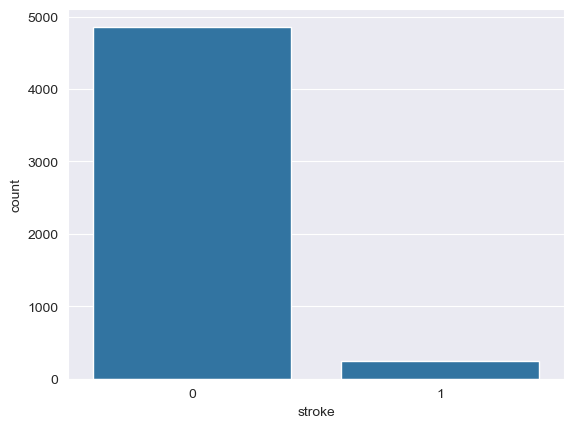

In [14]:
sns.countplot(data=df, x='stroke')

<Axes: xlabel='age', ylabel='Density'>

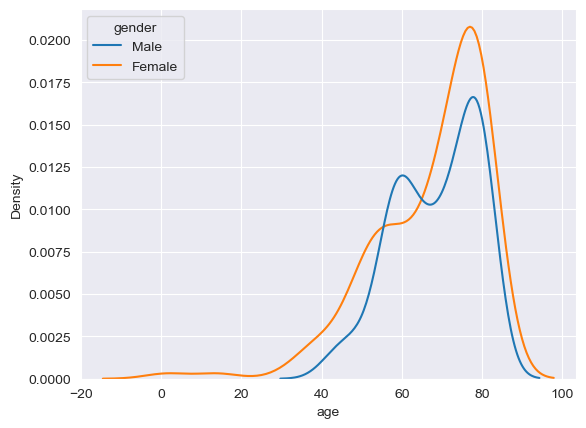

In [15]:
sns.kdeplot(data=df.query("stroke == 1"), x='age', hue='gender')

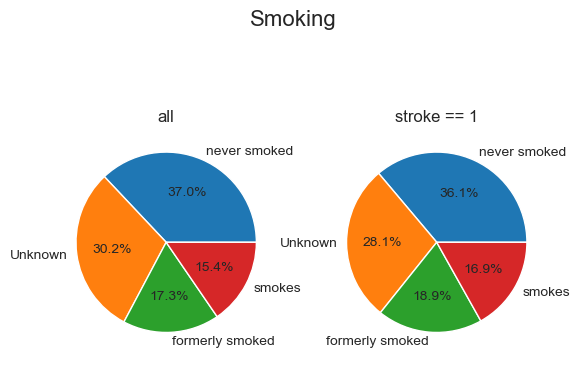

In [16]:
from matplotlib import pyplot as plt

with_stroke = df.query("stroke == 1").smoking_status.value_counts()
with_stroke.reindex(df.smoking_status.value_counts().index)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Smoking', fontsize=16)
ax1.set_title('all')
ax2.set_title('stroke == 1')
ax1.pie(df.smoking_status.value_counts(), autopct='%1.1f%%', labels=df.smoking_status.value_counts().index)
ax2.pie(with_stroke, autopct='%1.1f%%', labels=df.smoking_status.value_counts().index);

<Axes: xlabel='gender', ylabel='count'>

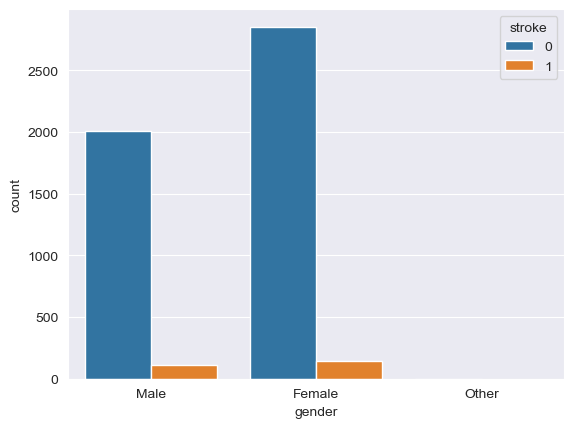

In [20]:
sns.countplot(data=df, x='gender', hue='stroke')

### Data Cleaning

In [21]:
df = df.drop(columns='id')

In [22]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [23]:
imputer = SimpleImputer(strategy='mean')
df.bmi = imputer.fit_transform(df[['bmi']])

In [24]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [25]:
df = df.drop(index=df.query("gender == 'Other'").index)

In [26]:
df = pd.get_dummies(data=df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

### Training

In [27]:
X = df.drop(columns='stroke')
y = df.stroke

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [28]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.952054794520548

In [30]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.9481409001956947

In [31]:
df.stroke.value_counts(normalize=True)

stroke
0    0.951262
1    0.048738
Name: proportion, dtype: float64

### Evaluierung

![confusion-matrix](./assets/confusion-matrix.jpeg)
* Unser model hat gelernt, fast immer 0 zu predicten
* Weil 0 fast immer richtig ist (Vergleiche: ein model, dass predicted ob jetzt die Welt untergeht und immer 0 predicted hat 100% accuracy)

In [32]:
confusion_matrix(y_test, forest.predict(X_test))

array([[969,   3],
       [ 50,   0]])

![accuracy](./assets/accuracy.jpeg)
![precision](./assets/precision.jpeg)
![recall](./assets/recall.jpeg)

* accuracy -> balanced Klassen
* precision -> FP furchtbar (Spam-detection, Recommendation)
* recall -> FN furchtbar, ALLE positiven (Medizin)
* gleich wichtig -> f1, auc

In [32]:
confusion_matrix(y_test, forest.predict(X_test))

array([[969,   3],
       [ 50,   0]])

In [33]:
print(classification_report(y_test, forest.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



#### Precision-Recall-Tradeoff
![prec-recall-tradeoff-1](./assets/prec-recall-tradeoff-1.webp)
![prec-recall-tradeoff-2](./assets/prec-recall-tradeoff-2.webp)
![prec-recall-tradeoff-3](./assets/prec-recall-tradeoff-3.webp)

In [34]:
forest_cv = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions={
        'n_estimators': randint(100, 500),
        'max_features': [1.0, 'sqrt', 'log2'],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    },
    n_jobs=2,
    scoring='recall',
    cv=3,
    n_iter=20,
)
forest_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=2,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_features': [1.0, 'sqrt', 'log2'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x179e16450>},
                   scoring='recall')

In [35]:
confusion_matrix(y_test, forest_cv.best_estimator_.predict(X_test))

array([[972,   0],
       [ 49,   1]])

In [39]:
log_reg_cv = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'solver': ['newton-cg', 'lbfgs'], # sag(a) doesnt converge
        'class_weight': [None, 'balanced']
    },
    n_jobs=2,
    scoring='recall',
    cv=3,
)
log_reg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=2,
             param_grid={'class_weight': [None, 'balanced'],
                         'solver': ['newton-cg', 'lbfgs']},
             scoring='recall')

In [37]:
print(classification_report(y_test, log_reg_cv.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84       972
           1       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022
